In [65]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
# Generate a random problem np.random.seed(0)
m, n= 40, 25
A = np.random.rand(m, n)
b = np.random.randn(m)
# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
objective = cp.Minimize(cp.sum_squares(A @ x - b)) 
prob = cp.Problem(objective)
prob.solve(solver = cp.GUROBI ,verbose = True)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 09 03:37:57 PM: Your problem has 25 variables, 0 constraints, and 0 parameters.
(CVXPY) May 09 03:37:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 03:37:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 03:37:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 03:37:57 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 09 03:37:57 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

20.994320888151584

In [14]:
import pandas as pd
import networkx as nx

In [23]:
bus_data = pd.read_csv('Bus.csv').dropna()
branch_data = pd.read_csv('Branch.csv').dropna()
load_data = pd.read_csv('Load.csv').dropna()
generation_data = pd.read_csv('Generation.csv').dropna()
print(len(branch_data))

186


In [42]:
# question 1.d
# build the vectors of constants
# all the costs
c_l = generation_data['LinearCost'].to_numpy()
c_nl = generation_data['NoLoadCost'].to_numpy()
c_su = generation_data['StartupCost'].to_numpy()
c_sd = generation_data['ShutdownCost'].to_numpy()
c_r = generation_data['ReserveCost'].to_numpy()

In [86]:
# Pl
Pl = np.expand_dims(branch_data['rateA'].to_numpy() / 100, axis=1)

In [92]:
# b: shall we divide it by 100?
b = branch_data['B(susceptance)'].to_numpy() / 100
print(b.shape)

(186,)


In [45]:
# M
N = bus_data.shape[0]
E = branch_data.shape[0]
bus_mappings = {bus:bus-1 for bus in bus_data['BusNumber']}
M = np.zeros((N, E))
for idx, (fbus, tbus) in enumerate(zip(branch_data['from_bus'], branch_data['to_bus'])):
    M[bus_mappings[fbus], idx] = 1
    M[bus_mappings[tbus], idx] = -1
print(M.shape)


(118, 186)


In [46]:
# B
B = np.dot(np.dot(M, np.diag(b)), M.T)
print(B.shape)

(118, 118)


In [47]:
# p
p_max = generation_data['Pmax'] / 100
p_min = generation_data['Pmin'] / 100

In [48]:
# selection matrix Eg
Ng = generation_data.shape[0]
Eg = np.zeros((N, Ng))
for i in range(Ng):
    Eg[generation_data['Bus'][i] - 1, i] = 1
print(Eg[9])

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [49]:
# ramps
r_hr = generation_data['HourlyRamp']
r_su = generation_data['Startup/ShutdownRamp']
r_sd = generation_data['Startup/ShutdownRamp']

In [77]:
# question 1.e
T = 24
Pload = np.expand_dims(bus_data['Pload'], axis=1)
day1 = np.expand_dims(load_data['Day1'], axis=1).T
day2 = np.expand_dims(load_data['Day2'], axis=1).T
day3 = np.expand_dims(load_data['Day3'], axis=1).T
day4 = np.expand_dims(load_data['Day4'], axis=1).T
day5 = np.expand_dims(load_data['Day5'], axis=1).T

P1 = (Pload @ day1) / 100
P2 = (Pload @ day2) / 100
P3 = (Pload @ day3) / 100
P4 = (Pload @ day4) / 100
P5 = (Pload @ day5) / 100

In [78]:
total_load = np.zeros((5, 24))
for i in range(24):
    total_load[0, i] = np.sum(P1[:, i])
    total_load[1, i] = np.sum(P2[:, i])
    total_load[2, i] = np.sum(P3[:, i])
    total_load[3, i] = np.sum(P4[:, i])
    total_load[4, i] = np.sum(P5[:, i])
print(total_load[0])

[2801.78 2666.21 2530.64 2485.45 2485.45 2530.64 3118.11 3615.2  4021.91
 4067.1  4067.1  4021.91 4021.91 4021.91 3931.53 3976.72 4157.48 4202.67
 4202.67 4067.1  3841.15 3479.63 3072.92 2666.21]


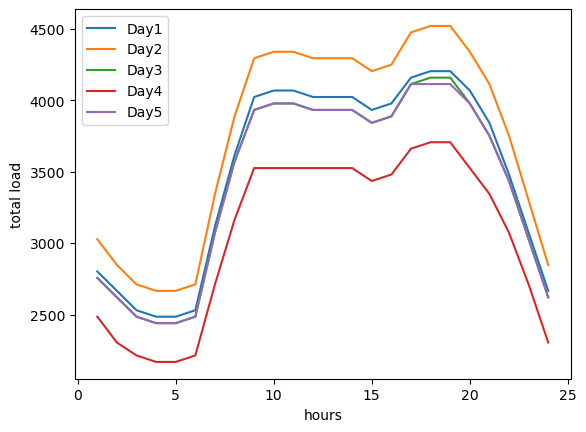

In [79]:
hours = np.arange(1, 25)
plt.plot(hours, total_load[0], label="Day1")
plt.plot(hours, total_load[1], label="Day2")
plt.plot(hours, total_load[2], label="Day3")
plt.plot(hours, total_load[3], label="Day4")
plt.plot(hours, total_load[4], label="Day5")
plt.xlabel("hours")
plt.ylabel("total load")
plt.legend()
plt.show()

In [74]:
# question 1.f
# uc.py
# the first day

p = cp.Variable((generation_data.shape[0],T))
r = cp.Variable((generation_data.shape[0],T))
theta = cp.Variable((N,T))
u = cp.Variable((generation_data.shape[0],T),boolean = True) # Commitment variable
v = cp.Variable((generation_data.shape[0],T),boolean = True) # Startup variable
w = cp.Variable((generation_data.shape[0],T),boolean = True) # Shutdown variable

In [75]:
# is the given formula incorrect?
obj = cp.Minimize(cp.sum(c_l.T@p + c_su.T@v + c_sd.T@w + c_nl.T@u + c_r.T@r))

In [107]:
power_flow_constraints = [Eg@p - P1 == B@theta]
flow_limits = [(-Pl)@np.ones((1,T)) <= np.diag(b)@M.T@theta, np.diag(b)@M.T@theta <= Pl@np.ones((1,T))]

# ??? why transpose for these diags for these limits
# generator_limits = [np.diag(p_min.T[0])@u + r <= p, p <= np.diag(p_max.T[0])@u - r]
generator_limits = [np.diag(p_min)@u + r <= p, p <= np.diag(p_max)@u - r]
ramp_limits_startup = [p[:,i] - p[:,i-1] <= np.diag(r_hr)@u[:,i-1] + np.diag(r_su)@v[:,i] for i in range(1,T)]
ramp_limits_shutdown = [p[:,i-1] - p[:,i] <= np.diag(r_hr)@u[:,i] + np.diag(r_su)@w[:,i] for i in range(1,T)]

commitment_constraints = [v[:,i] - w[:,i] == u[:,i] - u[:,i-1] for i in range(1,T)]

In [108]:
min_up_time = generation_data['minUP']
min_down_time = generation_data['minDOWN']
min_up_time_constraints = []
for idx, utime in enumerate(min_up_time):
    for t in range(utime-1,T):
        min_up_time_constraints += [cp.sum(v[idx,t-utime+1:t+1]) <= u[idx,t]]

min_down_time_constraints = []
for idx, dtime in enumerate(min_down_time):
    for t in range(dtime-1,T):
        min_down_time_constraints += [cp.sum(w[idx,t-dtime+1:t+1]) <= 1-u[idx,t]]

In [109]:
reserve_constraints = [cp.sum(r[:,t]) >= 0.07*cp.sum(P1[:,t]) for t in range(T)]
reserve_constraints += [cp.sum(r[:,t]) >= p[idx,t] + r[idx,t] for t in range(T) for idx,_ in enumerate(p_max)]
reserve_constraints += [r <= np.diag(p_max)@u, r >= 0]

In [110]:
constraints = power_flow_constraints + flow_limits + generator_limits + commitment_constraints + reserve_constraints + ramp_limits_startup + ramp_limits_shutdown + min_up_time_constraints + min_down_time_constraints

prob = cp.Problem(obj, constraints)
res = prob.solve(solver = cp.GUROBI,verbose=True,MIPgap = 0.01)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 09 05:34:22 PM: Your problem has 9312 variables, 3465 constraints, and 0 parameters.
(CVXPY) May 09 05:34:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 09 05:34:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 09 05:34:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 09 05:34:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 09 05:34:22 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixS

C:\Users\sunsh\miniconda3\lib\site-packages\cvxpy\problems\problem.py:1391: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)
